# Project 3 - Solving PDEs using Physics Informed Neural Networks (PINNs)
## Grid search for hyperparameter settings
This notebook shows a selection of grid searches and randomized grid searches done for with the PINN-implementation based on ...


### Notebook initial imports and defaults

In [3]:
from networkFlow import *
from PDEq import *
from support import *

import autograd.numpy as anp
import numpy as np
from math import log10

import matplotlib.pyplot as plt

## Random seed
default_seed = 15; anp.random.seed(default_seed)

## Figure defaults
plt.rcParams["figure.figsize"] = (6,3); plt.rcParams["font.size"] = 10
cmap = 'hot_r'; bin_vals = 7

## --- Network initial defaults --- ##
## Collocation tensor parameters
c_points = 1000; b_points = 20; i_points = 20

## Activation function
hidden_func = 'swish' # sigmoid, relu, elu, leaky_relu, tanh, swish, gelu, hard_sigmoid, exponential

## Layer configuration
l_size = 20; 
layer_out_sizes = [20,20,1]

act_funcs = []
for i in range(len(layer_out_sizes)-1):
    act_funcs.append(hidden_func)

## Output layer activation function set to identity
act_funcs.append(None); 

## Training parameters
epoch = 1000
gd_method = 'adam'

## --- Search parameters --- ##
num = 6
rand_num = 40

## --- Problem setup --- ##
## Differential equations
test_cases = ['diff1d','wave1d','wave2d','diff2d']
test = test_cases[2]

## Coefficients
c,D,amplitude = 0.7,0.1,0.2

if test == 'diff1d':
    PDE = Diffusion1D(sim_type='flow',amp=amplitude,D=D)
    t0,tN,x0,xN = 0,1,0,1
elif test == 'wave1d':
    PDE = Wave1D(sim_type='flow',amp=amplitude,c=c)
    t0,tN,x0,xN = 0,1,-1,1
elif test == 'wave2d':
    PDE = Wave2D(sim_type='flow',amp=amplitude,c=c)
    t0,tN = 0,1
    x0,xN,y0,yN = 0,1,0,1
elif test == 'diff2d':
    PDE = Diffusion2D(sim_type='flow',amp=amplitude,D=D)
    t0,tN = 0,1
    x0,xN,y0,yN = 0,1,0,1

## Defining the source function
f = PDE.right_hand_side

## Domain setup
Nt,Nx,Ny = 100,100,100

t_bound = [t0,tN]
x_bound = [x0,xN]

t = np.linspace(t_bound[0],t_bound[1],Nt)
x = np.linspace(x_bound[0],x_bound[1],Nx)

if test == 'wave2d' or test == 'diff2d':
    y_bound = [y0,yN]
    y = np.linspace(y_bound[0],y_bound[1],Ny)
    domain_array = np.array([t,x,y])
else:
    domain_array = np.array([t,x])

## Regular grid search 
### Learning rate, $\eta$, vs. regularization, $\lambda$
A grid search comparing the learning rate and regularization of the parameters of the network. Here, gradient descent is performed using the `Adagrad`-method.

In [4]:
## Training parameters
eta = np.logspace(-3,-1,num)
lmbda = np.logspace(-9,-7,num)

cost = np.zeros((len(eta),len(lmbda)))

for i in range(len(eta)):
    for j in range(len(lmbda)):
        ## Network initializtion
        if test == 'wave2d' or test == 'diff2d':
            TFNetwork = FFNNetworkFlow2D(layer_output_size=layer_out_sizes,
                           activation_functions=act_funcs,
                           PDE=PDE,
                           source_function=f,
                           domain_array=domain_array,
                           domain=[x_bound,y_bound],
                           gd_method=gd_method,
                           learning_rate=eta[i])

            ## Setup of collocation tensor
            TFNetwork.collocation_setup(bounds=(t_bound,x_bound,y_bound), colloc_points=c_points,
                            bound_points=b_points, init_points=i_points)
        else:
            TFNetwork = FFNNetworkFlow(layer_output_size=layer_out_sizes,
                            activation_functions=act_funcs,
                            PDE=PDE,
                            source_function=f,
                            domain_array=domain_array,
                            domain=x_bound,
                            gd_method=gd_method,
                            learning_rate=eta[i])

            ## Setup of collocation tensor
            TFNetwork.collocation_setup(bounds=(x_bound,t_bound), colloc_points=c_points,
                                    bound_points=b_points, init_points=i_points,
                                    plot_colloc=False)

        TFNetwork.create_layers(lmbda=lmbda[j])

        print('η,λ = %.2e, %.2e' %(eta[i],lmbda[j]))
        TFNetwork.train_network(epochs=epoch)

        cost[i,j] = TFNetwork.cost_history[-1]

η,λ = 1.00e-03, 1.00e-09
Final cost = 8.45400e-04
η,λ = 1.00e-03, 2.51e-09
Final cost = 8.23139e-04
η,λ = 1.00e-03, 6.31e-09
Final cost = 5.20918e-04
η,λ = 1.00e-03, 1.58e-08
Final cost = 6.92230e-04
η,λ = 1.00e-03, 3.98e-08
Final cost = 5.19273e-04
η,λ = 1.00e-03, 1.00e-07
Final cost = 5.52888e-04
η,λ = 2.51e-03, 1.00e-09
Final cost = 6.37435e-04
η,λ = 2.51e-03, 2.51e-09
Final cost = 4.86271e-04
η,λ = 2.51e-03, 6.31e-09
Final cost = 6.75865e-04
η,λ = 2.51e-03, 1.58e-08
Final cost = 4.98994e-04
η,λ = 2.51e-03, 3.98e-08
Final cost = 6.29934e-04
η,λ = 2.51e-03, 1.00e-07
Final cost = 6.63688e-04
η,λ = 6.31e-03, 1.00e-09
Final cost = 7.65503e-04
η,λ = 6.31e-03, 2.51e-09
Final cost = 5.72178e-04
η,λ = 6.31e-03, 6.31e-09
Final cost = 2.17514e-04
η,λ = 6.31e-03, 1.58e-08
Final cost = 8.32838e-04
η,λ = 6.31e-03, 3.98e-08
Final cost = 5.91743e-04
η,λ = 6.31e-03, 1.00e-07
Final cost = 4.47118e-04
η,λ = 1.58e-02, 1.00e-09
Final cost = 1.78466e-04
η,λ = 1.58e-02, 2.51e-09
Final cost = 4.30445e-04


Min cost for:
η = 3.981e-02
λ = 2.512e-09
Final cost = 1.43444e-04


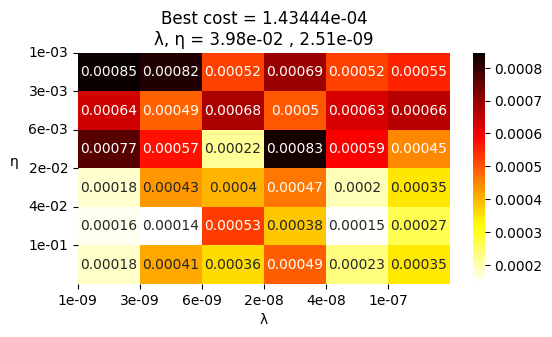

In [5]:
fig,ax = lambda_eta(cost,[lmbda,eta],
                    axis_tick_labels=[[f'{y:.0e}' for y in lmbda],[f'{y:.0e}' for y in eta]],
                    cbar_lim=[cost.min(),cost.max()],cmap=cmap
                    )

fig.set_size_inches(6,3)

min_cost_idx = np.argmin(cost); min_cost_pos = np.unravel_index(min_cost_idx, cost.shape)
ax.set_title('Best cost = %.5e\nλ, η = %.2e , %.2e' %(cost[min_cost_pos],eta[min_cost_pos[0]],lmbda[min_cost_pos[1]]))

print('Min cost for:\nη = %.3e\nλ = %.3e'%(eta[min_cost_pos[0]],lmbda[min_cost_pos[1]]))
print('Final cost = %.5e' %cost[min_cost_pos])

## Randomized grid searchs
The following part performs a randomized grid search for the optimal hyperparameters for the chosen PDE-problem. 

It does searches of random combinations of learning rate, $\eta$, regularization, $\lambda$, epochs, $e$, network depth, $d$, and hidden layer width, $M$. 

The ranges currently set up in the cells below are ranges that was found to give good results for the chosen PDE-problem.
### Search: Learning rate, $\eta$, vs. regularization, $\lambda$

In [6]:
## Search parameters
eta_range = [1e-3,1e-1]
lmbda_range = [1e-9,1e-7]

cost = np.zeros(rand_num)
etas = np.zeros_like(cost)
lmbdas = np.zeros_like(etas)

for i in range(rand_num):
    ## Picking parameters from uniform distribution
    eta = 10 ** np.random.uniform(log10(eta_range[0]), log10(eta_range[1])); etas[i] = eta
    lmbda = 10 ** np.random.uniform(log10(lmbda_range[0]), log10(lmbda_range[1])); lmbdas[i] = lmbda
    
    ## Network initializtion
    if test == 'wave2d' or test == 'diff2d':
        TFNetwork = FFNNetworkFlow2D(layer_output_size=layer_out_sizes,
                           activation_functions=act_funcs,
                           PDE=PDE,
                           source_function=f,
                           domain_array=domain_array,
                           domain=[x_bound,y_bound],
                           gd_method=gd_method,
                           learning_rate=eta)

        ## Setup of collocation tensor
        TFNetwork.collocation_setup(bounds=(t_bound,x_bound,y_bound), colloc_points=c_points,
                            bound_points=b_points, init_points=i_points)
    else:
        TFNetwork = FFNNetworkFlow(layer_output_size=layer_out_sizes,
                            activation_functions=act_funcs,
                            PDE=PDE,
                            source_function=f,
                            domain_array=domain_array,
                            domain=x_bound,
                            gd_method=gd_method,
                            learning_rate=eta)

        ## Setup of collocation tensor
        TFNetwork.collocation_setup(bounds=(x_bound,t_bound), colloc_points=c_points,
                                    bound_points=b_points, init_points=i_points,
                                    plot_colloc=False)

    TFNetwork.create_layers(lmbda=lmbda)

    print('η, λ = %.2e, %.2e' %(eta,lmbda))
    TFNetwork.train_network(epochs=epoch)

    #cost.append(TFNetwork.cost_history[-1])
    cost[i] = TFNetwork.cost_history[-1]

η, λ = 1.20e-02, 6.63e-08
Final cost = 3.01988e-04
η, λ = 2.10e-02, 1.27e-08
Final cost = 1.70748e-04
η, λ = 1.35e-03, 1.68e-08
Final cost = 8.55342e-04
η, λ = 5.06e-03, 1.62e-08
Final cost = 5.29393e-04
η, λ = 2.93e-03, 1.98e-09
Final cost = 7.14788e-04
η, λ = 7.57e-02, 1.96e-09
Final cost = 2.74773e-04
η, λ = 5.56e-03, 2.04e-08
Final cost = 3.42030e-04
η, λ = 8.78e-03, 1.25e-09
Final cost = 5.21489e-04
η, λ = 2.38e-02, 8.27e-08
Final cost = 2.99098e-04
η, λ = 5.76e-02, 2.52e-09
Final cost = 2.18430e-04
η, λ = 1.07e-02, 3.56e-08
Final cost = 1.64725e-04
η, λ = 2.69e-03, 7.20e-09
Final cost = 5.92299e-04
η, λ = 1.58e-02, 1.90e-09
Final cost = 1.88606e-04
η, λ = 1.65e-02, 4.45e-09
Final cost = 4.26241e-04
η, λ = 3.92e-03, 1.01e-09
Final cost = 7.94119e-04
η, λ = 2.63e-03, 5.38e-09
Final cost = 7.93255e-04
η, λ = 1.19e-02, 1.12e-09
Final cost = 6.59003e-04
η, λ = 2.08e-02, 1.86e-08
Final cost = 5.17325e-04
η, λ = 9.13e-03, 2.41e-08
Final cost = 6.25402e-04
η, λ = 1.28e-03, 1.20e-08
Final

Min cost for:
η = 1.706e-02
λ = 4.119e-09
Final cost = 1.57684e-04


/home/anders_tb/02-uio/fysstk4155/project-3-fys-stk4155/01-main/support.py:397: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, color='1', edgecolor='none'))


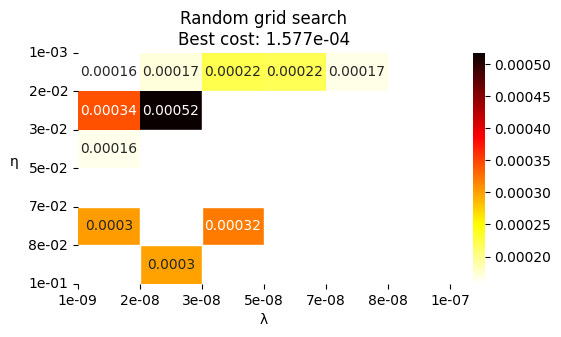

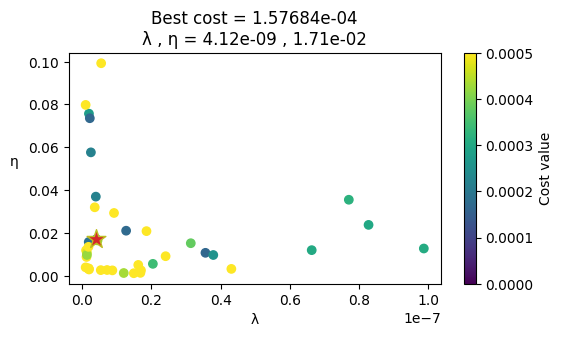

In [16]:
fig_h,ax_h = rand_heatmap(cost,[lmbdas,etas],
             axis_tick_labels='scientific',axis_labels=['λ','η'],
             bin_vals=bin_vals,cmap=cmap,
             cbar_lim=[cost.min(),cost.max()]
             )

fig_s,ax_s = rand_scatter(cost,[lmbdas,etas],axis_labels=['λ','η'],cmap='viridis',#cmap,
                          cbar_lim=[0.,0.0005])

fig_h.set_size_inches(6,3)
fig_s.set_size_inches(6,3) 

min_cost_idx = cost.argmin()
print('Min cost for:\nη = %.3e\nλ = %.3e'%(etas[min_cost_idx],lmbdas[min_cost_idx]))
print('Final cost = %.5e' %cost[min_cost_idx])

### Search: Network depth, $d$, vs. hidden layer size, $M$ 

In [17]:
## Restating training parameters
eta = 1e-2
lmbda = 1e-8

## Search parameters
d_range = [1,6]
M_range = [1,50]

cost = np.zeros(rand_num)
d = np.zeros(rand_num)
M = np.zeros(rand_num)

for i in range(rand_num):
    ## Setting random parameters
    l_size = np.random.randint(M_range[0],M_range[1]); M[i] = l_size
    num_lay = np.random.randint(d_range[0],d_range[1]); d[i] = num_lay
    
    act_funcs = []; layer_out_sizes = [1]
    for _ in range(num_lay):
        layer_out_sizes = [l_size] + layer_out_sizes
        act_funcs.append(hidden_func)

    ## Output layer activation function set to identity
    act_funcs.append(None); 

    ## Network initializtion
    if test == 'wave2d' or test == 'diff2d':
        TFNetwork = FFNNetworkFlow2D(layer_output_size=layer_out_sizes,
                           activation_functions=act_funcs,
                           PDE=PDE,
                           source_function=f,
                           domain_array=domain_array,
                           domain=[x_bound,y_bound],
                           gd_method=gd_method,
                           learning_rate=eta)

        ## Setup of collocation tensor
        TFNetwork.collocation_setup(bounds=(t_bound,x_bound,y_bound), colloc_points=c_points,
                            bound_points=b_points, init_points=i_points)
    else:
        TFNetwork = FFNNetworkFlow(layer_output_size=layer_out_sizes,
                            activation_functions=act_funcs,
                            PDE=PDE,
                            source_function=f,
                            domain_array=domain_array,
                            domain=x_bound,
                            gd_method=gd_method,
                            learning_rate=eta)

        ## Setup of collocation tensor
        TFNetwork.collocation_setup(bounds=(x_bound,t_bound), colloc_points=c_points,
                                    bound_points=b_points, init_points=i_points,
                                    plot_colloc=False)

    TFNetwork.create_layers(lmbda=lmbda)

    print('d, M = %i, %i' %(num_lay,l_size))
    TFNetwork.train_network(epochs=epoch)

    #cost.append(TFNetwork.cost_history[-1])
    cost[i] = TFNetwork.cost_history[-1]

d, M = 5, 8
Final cost = 3.43072e-04
d, M = 1, 6
Final cost = 7.35201e-04
d, M = 4, 33
Final cost = 3.01548e-04
d, M = 3, 2
Final cost = 2.67370e-03
d, M = 4, 38
Final cost = 7.29135e-05
d, M = 2, 10
Final cost = 6.81932e-04
d, M = 5, 39
Final cost = 2.34410e-04
d, M = 3, 43
Final cost = 1.39553e-04
d, M = 5, 16
Final cost = 1.46538e-04
d, M = 2, 46
Final cost = 3.70443e-04
d, M = 4, 39
Final cost = 2.18917e-04
d, M = 4, 15
Final cost = 4.74965e-04
d, M = 1, 38
Final cost = 6.37611e-04
d, M = 5, 16
Final cost = 4.31462e-04
d, M = 1, 11
Final cost = 1.52536e-03
d, M = 1, 48
Final cost = 5.80351e-04
d, M = 1, 31
Final cost = 6.05887e-04
d, M = 2, 6
Final cost = 6.12823e-04
d, M = 1, 39
Final cost = 6.72670e-04
d, M = 1, 21
Final cost = 6.95589e-04
d, M = 3, 29
Final cost = 4.40839e-04
d, M = 4, 18
Final cost = 3.72952e-04
d, M = 3, 45
Final cost = 3.04315e-04
d, M = 2, 40
Final cost = 2.17988e-04
d, M = 4, 37
Final cost = 1.64769e-04
d, M = 3, 5
Final cost = 6.40009e-04
d, M = 5, 36
Fina

Min cost for:
d = 4.000000
M = 38.000000
Final cost = 7.29135e-05


/home/anders_tb/02-uio/fysstk4155/project-3-fys-stk4155/01-main/support.py:397: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, color='1', edgecolor='none'))


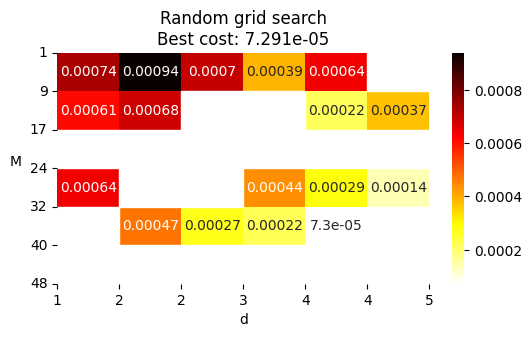

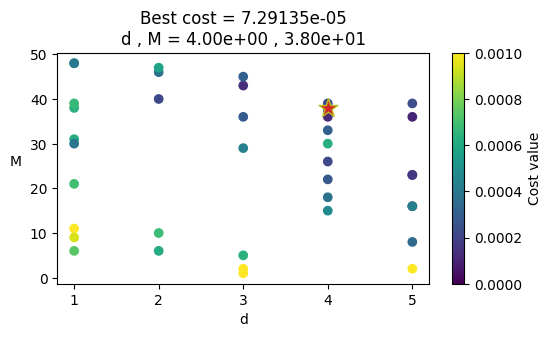

In [21]:
fig_h,ax_h = rand_heatmap(cost,[d,M],
             axis_tick_labels='float',axis_labels=['d','M'],
             bin_vals=bin_vals,cmap=cmap,
             cbar_lim=[cost.min(),cost.max()]
             )

fig_s,ax_s = rand_scatter(cost,[d,M],axis_labels=['d','M'],cmap='viridis',cbar_lim=[0.,0.001])

fig_h.set_size_inches(6,3)
fig_s.set_size_inches(6,3) 

min_cost_idx = cost.argmin()
print('Min cost for:\nd = %f\nM = %f'%(d[min_cost_idx],M[min_cost_idx]))
print('Final cost = %.5e' %cost[min_cost_idx])

### Search: Learning rate, $\eta$, vs. number of epochs, $e$

In [22]:
## Restating network structure parameters
layer_out_sizes = [20,20,1]
act_funcs = []
for i in range(len(layer_out_sizes)-1):
    act_funcs.append(hidden_func)
act_funcs.append(None)

## Search parameters
eta_range = [1e-3,1e-1]
epoch_range = [10,4000]

cost = np.zeros(rand_num)
etas = np.zeros_like(cost)
epochs = np.zeros_like(etas)

for i in range(rand_num):
    ## Picking random parameters
    eta = 10 ** np.random.uniform(log10(eta_range[0]), log10(eta_range[1])); etas[i] = eta
    epoch = np.random.randint(epoch_range[0],epoch_range[1]); epochs[i] = epoch
    
    ## Network initializtion
    if test == 'wave2d' or test == 'diff2d':
        TFNetwork = FFNNetworkFlow2D(layer_output_size=layer_out_sizes,
                           activation_functions=act_funcs,
                           PDE=PDE,
                           source_function=f,
                           domain_array=domain_array,
                           domain=[x_bound,y_bound],
                           gd_method=gd_method,
                           learning_rate=eta)

        ## Setup of collocation tensor
        TFNetwork.collocation_setup(bounds=(t_bound,x_bound,y_bound), colloc_points=c_points,
                            bound_points=b_points, init_points=i_points)
    else:
        TFNetwork = FFNNetworkFlow(layer_output_size=layer_out_sizes,
                            activation_functions=act_funcs,
                            PDE=PDE,
                            source_function=f,
                            domain_array=domain_array,
                            domain=x_bound,
                            gd_method=gd_method,
                            learning_rate=eta)

        ## Setup of collocation tensor
        TFNetwork.collocation_setup(bounds=(x_bound,t_bound), colloc_points=c_points,
                                    bound_points=b_points, init_points=i_points,
                                    plot_colloc=False)

    TFNetwork.create_layers(lmbda=lmbda)

    print('η, e = %.3e, %i' %(eta,epoch))
    TFNetwork.train_network(epochs=epoch)

    #cost.append(TFNetwork.cost_history[-1])
    cost[i] = TFNetwork.cost_history[-1]

η, e = 3.507e-03, 473
Final cost = 7.34648e-04
η, e = 1.919e-02, 672
Final cost = 5.77217e-04
η, e = 2.113e-03, 1832
Final cost = 4.24307e-04
η, e = 4.900e-02, 848
Final cost = 2.72510e-04
η, e = 9.168e-03, 3494
Final cost = 9.37780e-05
η, e = 2.765e-02, 1617
Final cost = 1.18378e-04
η, e = 2.950e-03, 3776
Final cost = 1.48008e-04
η, e = 8.336e-02, 22
Final cost = 1.05252e-02
η, e = 3.396e-02, 1357
Final cost = 2.43757e-04
η, e = 1.858e-02, 1215
Final cost = 2.78532e-04
η, e = 8.843e-03, 2634
Final cost = 6.51511e-05
η, e = 5.422e-03, 2638
Final cost = 2.72286e-04
η, e = 9.601e-02, 3556
Final cost = 1.43065e-05
η, e = 3.450e-02, 1319
Final cost = 4.56719e-04
η, e = 4.480e-03, 40
Final cost = 6.18559e-03
η, e = 2.515e-02, 676
Final cost = 8.10128e-04
η, e = 2.258e-02, 2132
Final cost = 1.74938e-04
η, e = 6.288e-03, 1626
Final cost = 5.51995e-04
η, e = 1.460e-02, 1248
Final cost = 2.01548e-04
η, e = 1.137e-03, 1525
Final cost = 4.92904e-04
η, e = 5.231e-03, 1440
Final cost = 6.52117e-04


Min cost for:
η = 5.794e-02
e = 3290
Final cost = 1.19878e-05


/home/anders_tb/02-uio/fysstk4155/project-3-fys-stk4155/01-main/support.py:397: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, color='1', edgecolor='none'))


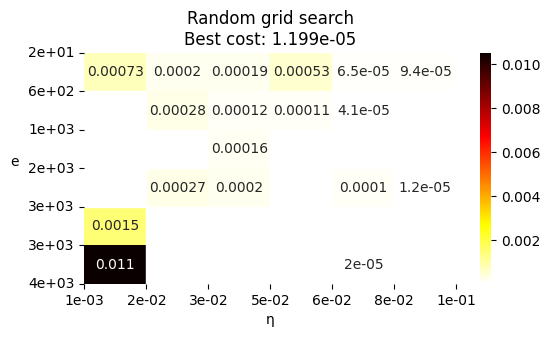

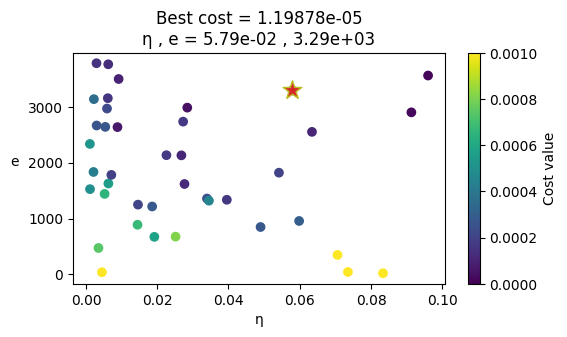

In [27]:
fig_h,ax_h = rand_heatmap(cost,[etas,epochs],
             axis_tick_labels='scientific',axis_labels=['η','e'],
             bin_vals=bin_vals,cmap=cmap,
             cbar_lim=[cost.min(),cost.max()]
             )

fig_s,ax_s = rand_scatter(cost,[etas,epochs],axis_labels=['η','e'],cbar_lim=[0.,0.001],cmap='viridis')

fig_h.set_size_inches(6,3)
fig_s.set_size_inches(6,3)

min_cost_idx = cost.argmin()
print('Min cost for:\nη = %.3e\ne = %i'%(etas[min_cost_idx],epochs[min_cost_idx]))
print('Final cost = %.5e' %cost[min_cost_idx])

### Search: Learning rate, $\eta$ vs., network depth, $d$

In [28]:
## Restating training parameters
epoch = 1000

## Search parameters
eta_range = [1e-3,1e-1]
d_range = [1,6]

cost = np.zeros(rand_num)
etas = np.zeros(rand_num)
d = np.zeros(rand_num)

for i in range(rand_num):
    eta = 10 ** np.random.uniform(log10(eta_range[0]), log10(eta_range[1])); etas[i] = eta

    num_lay = np.random.randint(d_range[0],d_range[1]); d[i] = num_lay
    
    act_funcs = []; layer_out_sizes = [1]
    for _ in range(num_lay):
        layer_out_sizes = [l_size] + layer_out_sizes
        act_funcs.append(hidden_func)

    ## Output layer activation function set to identity
    act_funcs.append(None); 

    ## Network initializtion
    if test == 'wave2d' or test == 'diff2d':
        TFNetwork = FFNNetworkFlow2D(layer_output_size=layer_out_sizes,
                           activation_functions=act_funcs,
                           PDE=PDE,
                           source_function=f,
                           domain_array=domain_array,
                           domain=[x_bound,y_bound],
                           gd_method=gd_method,
                           learning_rate=eta)

        ## Setup of collocation tensor
        TFNetwork.collocation_setup(bounds=(t_bound,x_bound,y_bound), colloc_points=c_points,
                            bound_points=b_points, init_points=i_points)
    else:
        TFNetwork = FFNNetworkFlow(layer_output_size=layer_out_sizes,
                            activation_functions=act_funcs,
                            PDE=PDE,
                            source_function=f,
                            domain_array=domain_array,
                            domain=x_bound,
                            gd_method=gd_method,
                            learning_rate=eta)

        ## Setup of collocation tensor
        TFNetwork.collocation_setup(bounds=(x_bound,t_bound), colloc_points=c_points,
                                    bound_points=b_points, init_points=i_points,
                                    plot_colloc=False)

    TFNetwork.create_layers(lmbda=lmbda)

    print('η, d = %.3e, %i' %(eta,num_lay))
    TFNetwork.train_network(epochs=epoch)

    #cost.append(TFNetwork.cost_history[-1])
    cost[i] = TFNetwork.cost_history[-1]

η, d = 2.104e-02, 4
Final cost = 2.00770e-03
η, d = 1.935e-03, 5
Final cost = 2.69351e-03
η, d = 6.340e-03, 4
Final cost = 2.50326e-03
η, d = 3.002e-03, 1
Final cost = 7.56038e-03
η, d = 3.048e-03, 5
Final cost = 2.65083e-03
η, d = 8.476e-03, 1
Final cost = 3.89686e-03
η, d = 3.967e-02, 1
Final cost = 6.05564e-03
η, d = 1.274e-02, 4
Final cost = 6.02599e-04
η, d = 3.752e-03, 3
Final cost = 3.40867e-03
η, d = 2.816e-03, 1
Final cost = 6.06267e-03
η, d = 1.737e-03, 4
Final cost = 8.90517e-03
η, d = 7.599e-02, 4
Final cost = 2.02632e-03
η, d = 1.464e-03, 5
Final cost = 3.71229e-03
η, d = 1.456e-03, 1
Final cost = 9.63439e-03
η, d = 1.095e-03, 4
Final cost = 2.66198e-03
η, d = 3.860e-03, 5
Final cost = 2.66586e-03
η, d = 1.118e-02, 3
Final cost = 5.42204e-03
η, d = 1.091e-03, 4
Final cost = 2.97499e-03
η, d = 8.670e-02, 5
Final cost = 2.32747e-03
η, d = 1.567e-03, 2
Final cost = 6.97648e-03
η, d = 2.269e-03, 5
Final cost = 4.63137e-03
η, d = 9.160e-03, 1
Final cost = 4.50866e-03
η, d = 1.4

Min cost for:
η = 1.274e-02
d = 4
Final cost = 6.02599e-04


/home/anders_tb/02-uio/fysstk4155/project-3-fys-stk4155/01-main/support.py:397: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, color='1', edgecolor='none'))


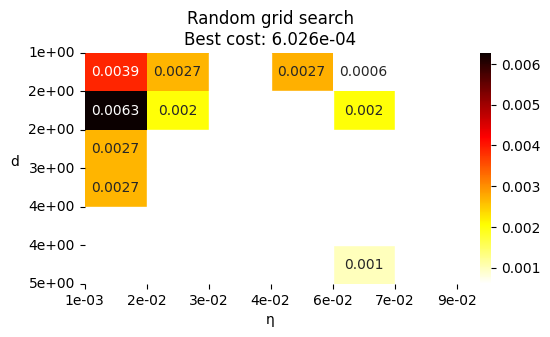

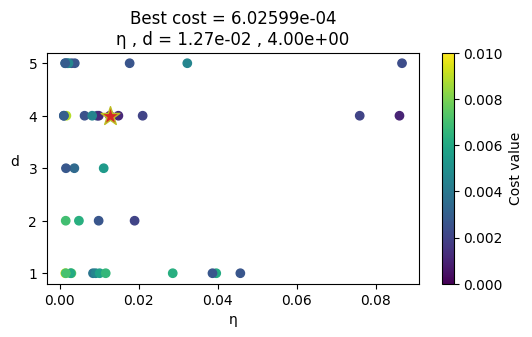

In [31]:
fig_h,ax_h = rand_heatmap(cost,[etas,d],
             axis_tick_labels='scientific',axis_labels=['η','d'],
             bin_vals=bin_vals,cmap=cmap,
             cbar_lim=[cost.min(),cost.max()]
             )

fig_s,ax_s = rand_scatter(cost,[etas,d],cmap='viridis',cbar_lim=[0.,0.01],axis_labels=['η','d'])

fig_h.set_size_inches(6,3)
fig_s.set_size_inches(6,3)

min_cost_idx = cost.argmin()
print('Min cost for:\nη = %.3e\nd = %i'%(etas[min_cost_idx],d[min_cost_idx]))
print('Final cost = %.5e' %cost[min_cost_idx])


### Search: Learning rate, $\eta$ vs. hidden layer width, $M$

In [32]:
## Restating network parameters
num_lay = 4

## Search parameters
eta_range = [1e-3,1e-1]
M_range = [1,50]

cost = np.zeros(rand_num)
etas = np.zeros(rand_num)
M = np.zeros(rand_num)

for i in range(rand_num):
    ## Picking random parameters
    l_size = np.random.randint(M_range[0],M_range[1]); M[i] = l_size
    eta = 10 ** np.random.uniform(log10(eta_range[0]), log10(eta_range[1])); etas[i] = eta
    
    act_funcs = []; layer_out_sizes = [1]
    for _ in range(num_lay):
        layer_out_sizes = [l_size] + layer_out_sizes
        act_funcs.append(hidden_func)
    act_funcs.append(None); 

    ## Network initializtion
    if test == 'wave2d' or test == 'diff2d':
        TFNetwork = FFNNetworkFlow2D(layer_output_size=layer_out_sizes,
                           activation_functions=act_funcs,
                           PDE=PDE,
                           source_function=f,
                           domain_array=domain_array,
                           domain=[x_bound,y_bound],
                           gd_method=gd_method,
                           learning_rate=eta)

        ## Setup of collocation tensor
        TFNetwork.collocation_setup(bounds=(t_bound,x_bound,y_bound), colloc_points=c_points,
                            bound_points=b_points, init_points=i_points)
    else:
        TFNetwork = FFNNetworkFlow(layer_output_size=layer_out_sizes,
                            activation_functions=act_funcs,
                            PDE=PDE,
                            source_function=f,
                            domain_array=domain_array,
                            domain=x_bound,
                            gd_method=gd_method,
                            learning_rate=eta)

        ## Setup of collocation tensor
        TFNetwork.collocation_setup(bounds=(x_bound,t_bound), colloc_points=c_points,
                                    bound_points=b_points, init_points=i_points,
                                    plot_colloc=False)

    TFNetwork.create_layers(lmbda=lmbda)

    print('η, M = %.3e, %i' %(eta,l_size))
    TFNetwork.train_network(epochs=epoch)

    #cost.append(TFNetwork.cost_history[-1])
    cost[i] = TFNetwork.cost_history[-1]

η, M = 2.732e-02, 13
Final cost = 2.73947e-05
η, M = 1.002e-02, 14
Final cost = 1.90743e-04
η, M = 1.577e-03, 35
Final cost = 8.87616e-04
η, M = 4.336e-03, 42
Final cost = 7.80398e-04
η, M = 2.161e-02, 2
Final cost = 3.87586e-03
η, M = 1.608e-02, 34
Final cost = 1.57075e-04
η, M = 4.793e-02, 15
Final cost = 1.82257e-04
η, M = 1.125e-03, 15
Final cost = 5.98295e-04
η, M = 1.604e-03, 35
Final cost = 4.35115e-04
η, M = 1.727e-03, 45
Final cost = 6.31140e-04
η, M = 7.293e-02, 17
Final cost = 4.57091e-04
η, M = 5.738e-03, 9
Final cost = 1.36588e-04
η, M = 2.309e-02, 4
Final cost = 3.72641e-04
η, M = 1.995e-03, 25
Final cost = 5.88904e-04
η, M = 8.149e-03, 47
Final cost = 2.43242e-04
η, M = 2.381e-03, 23
Final cost = 5.69166e-04
η, M = 8.672e-03, 11
Final cost = 3.81810e-04
η, M = 6.520e-03, 28
Final cost = 4.40442e-04
η, M = 1.772e-03, 48
Final cost = 4.91530e-04
η, M = 2.335e-03, 42
Final cost = 5.60987e-04
η, M = 4.468e-03, 38
Final cost = 6.70895e-04
η, M = 2.531e-03, 15
Final cost = 2.4

Min cost for:
η = 2.732e-02
M = 13
Final cost = 2.73947e-05


/home/anders_tb/02-uio/fysstk4155/project-3-fys-stk4155/01-main/support.py:397: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, color='1', edgecolor='none'))


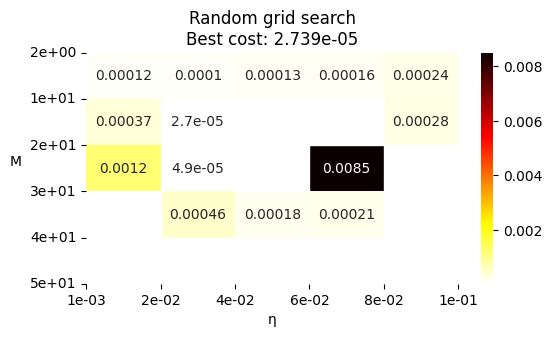

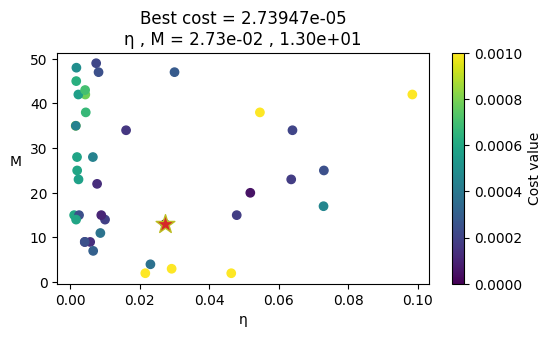

In [36]:
fig_h,ax_h = rand_heatmap(cost,[etas,M],
             axis_tick_labels='scientific',axis_labels=['η','M'],
             bin_vals=bin_vals-1,cmap=cmap,
             cbar_lim=[cost.min(),cost.max()]
             )

fig_s,ax_s = rand_scatter(cost,[etas,M],cmap='viridis',cbar_lim=[0.,0.001],axis_labels=['η','M'])

fig_h.set_size_inches(6,3)
fig_s.set_size_inches(6,3) 

min_cost_idx = cost.argmin()
print('Min cost for:\nη = %.3e\nM = %i'%(etas[min_cost_idx],M[min_cost_idx]))
print('Final cost = %.5e' %cost[min_cost_idx])